# How do errors propagate through the pseudobatch transformation?

In [1]:
import logging
import os

from functools import partial
from pprint import pprint


import arviz as az
import cmdstanpy
import numpy as np
import pandas as pd
from tqdm import tqdm
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from scipy.special import logit

from pseudobatch.data_correction import pseudobatch_transform
from pseudobatch.datasets import load_standard_fedbatch
from pseudobatch.error_propagation import run_error_propagation

# Don't print cmdstanpy warnings
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

{'stan_version_major': '2', 'stan_version_minor': '31', 'stan_version_patch': '0', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


# Statistical model

In order to understand how the pseudobatch transform propagates errors, we need a statistical model that describes how we think error arises in batch fermentation experiments. Luckily pseudobatch comes with one of those!

## Measurements

The statistical model assumes that the following quantities are measured with natural logarithmic scale errors:

| quantity |symbol for true value | symbol for measured value | symbol for $\ln$ scale error |
|----------|----------------------|-------------------------- |----------------------------- |
|container volume|$v$|$y_v$|$\sigma_v$||
|species concentration|$c$|$y_c$|$\sigma_c$|
|feed volume|$f$|$y_f$|$\sigma_f$|
|sample volume|$s$|$y_s$|$\sigma_s$|
|feed concentration|$cfeed$|$y_{cfeed}$|$\sigma_{cfeed}$|

The probabilistic relationship between the true values and the measured values is modelled as follows:

\begin{align*}
y_v &\sim LN(\ln{v}, \sigma_v) \\
y_c &\sim LN(\ln{c}, \sigma_c) \\
y_f &\sim LN(\ln{f + a_{pump}}, \sigma_f) \\
y_s &\sim LN(\ln{s}, \sigma_s) \\
y_{cfeed} &\sim LN(\ln{cfeed}, \sigma_{cfeed})
\end{align*}

In these equations $LN$ stands for the lognormal distribution with standard location and scale parameterisation. 

Note that the model for feed measurements includes a term $a_{pump}$. This is to model the effect of an unknown but common-to-all-measurements bias in feed measurements due to an inaccurate pump.

## Known quantities

As well as the values of all measurements, our model also assumes that the measurement errors are known exactly. These values are stored in a Python dictionary in the cell below:

In [2]:
KNOWN_QUANTITIES = {
    "sigma_v": 0.05,
    "sigma_c": [0.05] * 3,
    "sigma_f": 0.05,
    "sigma_s": 0.05,
    "sigma_cfeed": 0.05,
}

## Unknown quantities

The model also has unknown quantities. These are:

|symbol| Description|
|------|------------|
|$v_0$ | the volume of the container at the start of the experiment.|
|$m$ | a vector of per-sample species masses.|
|$a_s$| a vector of per-sample volumes, expressed as logit-scale fractions of the pre-sample volume.|
|$f_{nz}$| a vector containing the feed volume for each pre-sample interval where feeding took place.|
|$cf_{nz}$ | the concentration of feed in the feed solution if any.|
|$a_{pump}$| the factor according to which measurements of feed volume are biased, on $\ln$ scale|

Other quantities in the model---for example, the smaple volumes $v$---are calculated based on the values of the unknowns above. This parameterisation was chosen in order to ensure that independent prior distributions would be appropriate.

## Priors

The next cell shows the informative independent priors we chose for each unknown quantity. Note that the priors are specified by setting the 1% and 99% percentiles. Ideally, ignoring the measurement results there should be a 99% probability of the true value being greater than the 1% percentile and a 99% probability of the true value being lower than the 99% percentile.


In [3]:
PRIORS = {
    "prior_apump": {"pct1": np.log(1 - 0.1), "pct99": np.log(1 + 0.1)},
    "prior_as": {"pct1": logit(0.05), "pct99": logit(0.4)},
    "prior_v0": {"pct1": 1000, "pct99": 1030},
    "prior_m": [
        {"pct1": 200, "pct99": 200000},
        {"pct1": 2, "pct99": 2000},
        {"pct1": 200, "pct99": 200000},
    ],
    "prior_f_nonzero": {"pct1": 10, "pct99": 1000},
    "prior_cfeed_nonzero": {"pct1": 0.01, "pct99": 0.1},
}

# Load data

This cell loads some data and adds some useful columns.

In [4]:
SPECIES = ["Biomass", "Glucose", "Product"]

samples = load_standard_fedbatch(sampling_points_only=True)
samples["v_Feed_interval"] = np.concatenate(
    [np.array([samples["v_Feed_accum"].iloc[0]]), np.diff(samples["v_Feed_accum"])]
)
for species in SPECIES:
    samples[f"c_{species}_pseudobatch"] = pseudobatch_transform(
        measured_concentration=samples[f"c_{species}"],
        reactor_volume=samples["v_Volume"],
        accumulated_feed=samples["v_Feed_accum"],
        concentration_in_feed=0,
        sample_volume=samples["sample_volume"],
    )
samples.head().T

,0,1,2,3,4
Kc_s,0.150000,0.150000,0.150000,0.150000,0.150000
mu_max,0.300000,0.300000,0.300000,0.300000,0.300000
Yxs,1.850000,1.850000,1.850000,1.850000,1.850000
Yxp,0.821510,0.821510,0.821510,0.821510,0.821510
Yxco2,0.045193,0.045193,0.045193,0.045193,0.045193
F0,0.159031,0.159031,0.159031,0.159031,0.159031
mu0,0.100000,0.100000,0.100000,0.100000,0.100000
s_f,100.000000,100.000000,100.000000,100.000000,100.000000
sample_volume,100.000000,100.000000,100.000000,100.000000,100.000000
timestamp,10.000000,14.545455,19.090909,23.636364,28.181818


# Run error propagation

This cell runs the pseudobatch error propagation.

In [5]:
ERROR_PROPAGATION_ARGS = dict(        
    measured_concentration=samples[[f"c_{species}" for species in SPECIES]],
    reactor_volume=samples["v_Volume"],
    accumulated_feed=samples["v_Feed_accum"],
    concentration_in_feed=0,
    sample_volume=samples["sample_volume"],
    prior_input=PRIORS,
    known_quantities=KNOWN_QUANTITIES,
    species_names=SPECIES
)
idata = run_error_propagation(**ERROR_PROPAGATION_ARGS)

display(az.summary(idata.sample_stats))
idata

/Users/tedgro/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/tedgro/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lp,-164.261,5.839,-175.274,-153.734,0.148,0.105,1561.0,2427.0,1.00
acceptance_rate,0.881,0.124,0.676,1.000,0.002,0.001,4181.0,3402.0,1.00
step_size,0.371,0.012,0.354,0.386,0.006,0.004,4.0,4.0,inf
tree_depth,3.866,0.341,3.000,4.000,0.025,0.018,192.0,173.0,1.02
n_steps,14.464,2.678,7.000,15.000,0.047,0.034,3074.0,2858.0,1.02
diverging,0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
energy,195.841,8.121,180.806,211.347,0.216,0.153,1431.0,1921.0,1.00


Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> sample_stats_prior

Convert results to arviz `InferenceData`.

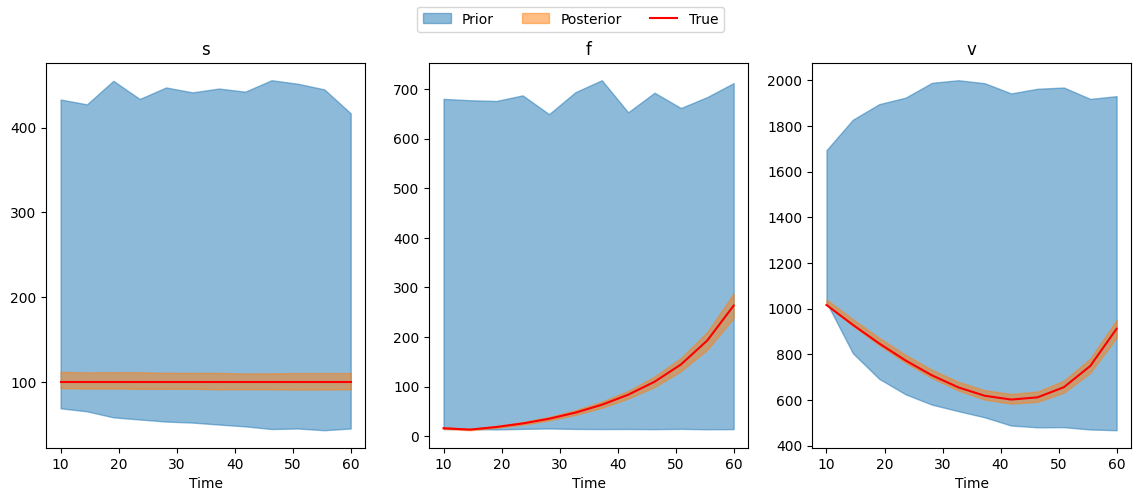

In [6]:
def plot_timecourse_qs(
    ax: plt.Axes,
    varname: str, 
    idata_group: xr.Dataset, 
    timepoints: pd.Series,
    coords: dict,
    quantiles: list = [0.025, 0.975],
    **fill_between_kwargs
) -> PolyCollection:
    var_draws = idata_group[varname]
    for k, v in coords.items():
        if k in var_draws.coords:
            var_draws = var_draws.sel({k:v})
    qs = var_draws.quantile(quantiles, dim=["chain", "draw"]).to_dataframe()[varname].unstack("quantile")
    low = qs[0.025].values
    high = qs[0.975].values
    x = timepoints.values
    return ax.fill_between(x, low, high, **fill_between_kwargs)


f, axes = plt.subplots(1, 3, figsize=[14, 5])
for ax, varname, true_value_colname in zip(
    axes, 
    ["s", "f", "v"], 
    ["sample_volume", "v_Feed_interval", "v_Volume"]
):
    pcs = []
    for idata_group, color in zip([idata.prior, idata.posterior], ["tab:blue", "tab:orange"]):
        pc = plot_timecourse_qs(
            ax,
            varname,
            idata_group,
            samples["timestamp"],
            {"species": ["Product"]},
            color=color,
            alpha=0.5,
        )
        pcs += [pc]
    line = ax.plot(samples["timestamp"], samples[true_value_colname], color="red")
    txt = ax.set(xlabel="Time", title=varname)
legend = f.legend([*pcs, line[0]], ["Prior", "Posterior", "True"], ncol=3, loc="upper center")

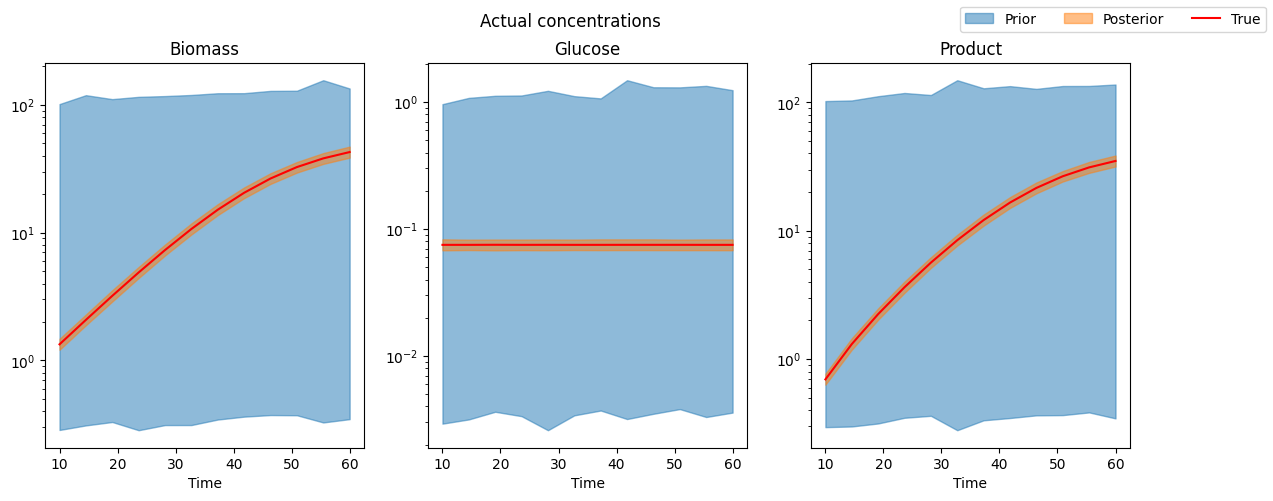

In [7]:
f, axes = plt.subplots(1, 3, figsize=[14, 5])
for ax, species, true_value_colname in zip(
    axes, SPECIES, ["c_" + s for s in SPECIES]
):
    pcs = []
    for idata_group, color in zip([idata.prior, idata.posterior], ["tab:blue", "tab:orange"]):
        pc = plot_timecourse_qs(
            ax,
            "c",
            idata_group,
            samples["timestamp"],
            {"species": [species]},
            color=color,
            alpha=0.5,
        )
        pcs += [pc]
    line = ax.plot(samples["timestamp"], samples[true_value_colname], color="red")
    txt = ax.set(xlabel="Time", title=species)
    ax.semilogy()

f.suptitle("Actual concentrations")
legend = f.legend([*pcs, line[0]], ["Prior", "Posterior", "True"], ncol=3, loc="upper right")

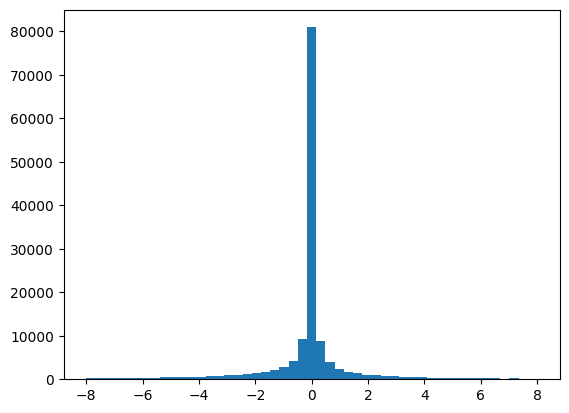

In [8]:
resids = (
    (idata.posterior["pseudobatch_c"] - samples[[f"c_{species}_pseudobatch" for species in SPECIES]].values)
    .to_dataframe()
)
resids 

ax = plt.hist(resids.stack().values, bins=np.linspace(-8, 8, 50))

# Compare product measurement error with final product uncertainty

In the next cell we try systematically changing the measurement error for $y_{c}$, then running the model in posterior mode and saving the width of the 99% posterior interval for the last value of $c$ in a dictionary called `widths`.

In [9]:
idata_ensemble = {}
last_sample_width_list = []

for sigma_c in tqdm(np.linspace(0.01, 1, 30)):
    known_quantities_iter = KNOWN_QUANTITIES | {"sigma_c": [sigma_c] * 3}
    ep_args_iter = ERROR_PROPAGATION_ARGS | {"known_quantities": known_quantities_iter}
    idata_ensemble[sigma_c] = run_error_propagation(**ep_args_iter)
    low, high = idata_ensemble[sigma_c].posterior["pseudobatch_c"].quantile([0.025, 0.975], dim=["chain", "draw"])
    last_sample_width_list.append((high - low).sel(sample=11).values)

last_sample_widths = pd.DataFrame(last_sample_width_list, index=idata_ensemble.keys(), columns=SPECIES)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:39<00:00,  1.33s/it]


Next we plot the hard-coded measurement error values against the posterior interval widths.

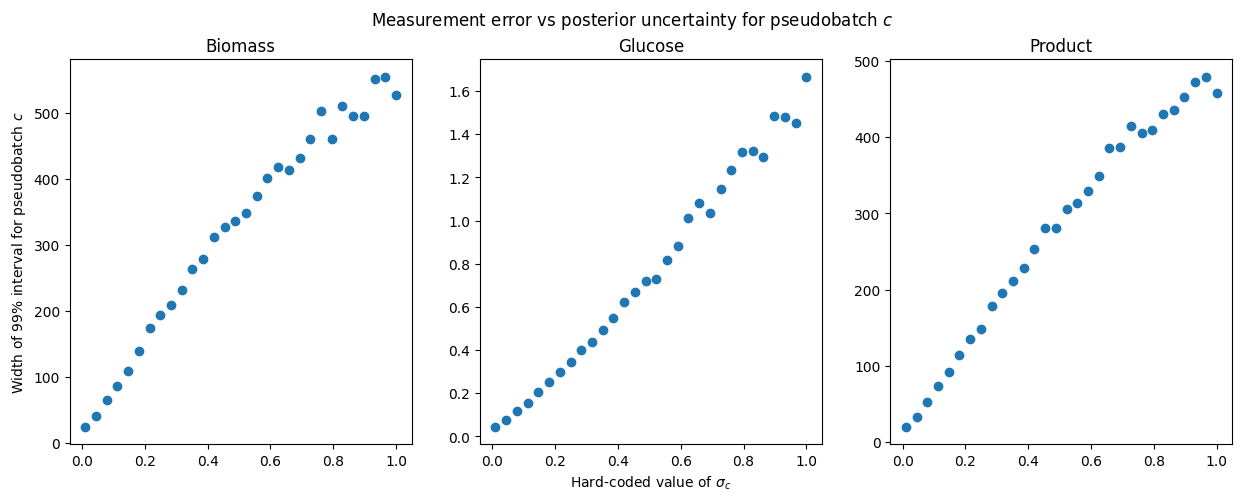

In [10]:
f, axes = plt.subplots(1, 3, figsize=[15, 5])
f.suptitle("Measurement error vs posterior uncertainty for pseudobatch $c$")
for ax, species in zip(axes, SPECIES):
    scatter = ax.scatter(last_sample_widths.index, last_sample_widths[species])
    text = ax.set(title=species)
xlabel = axes[1].set(xlabel="Hard-coded value of $\sigma_c$")
ylabel = axes[0].set(ylabel="Width of 99% interval for pseudobatch $c$")

There appears to be saturating linear relationship between the hardcoded measurement error and the width of the credible interval of the pseudo batch concentration. Thus, we can reject the hypothesis that the uncertainty is severely increased through the pseudo batch transformation. 

In [11]:
relative_width = last_sample_widths / samples[[f"c_{species}_pseudobatch" for species in SPECIES]].iloc[-1].values

for species in SPECIES:
    lin_coef = np.polyfit(relative_width.index, relative_width[species], deg=1)
    print(f"{species}: {lin_coef}")

Biomass: [2.7257369  0.25940273]
Glucose: [ 4.65711495 -0.12182353]
Product: [2.95520753 0.21452929]


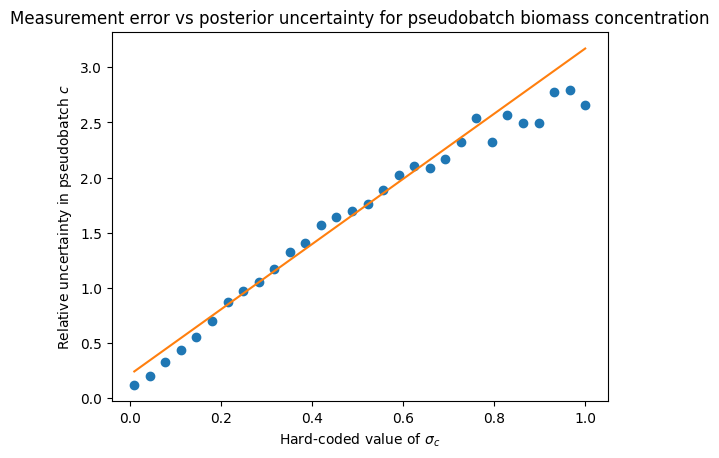

In [12]:
f, ax = plt.subplots()

scatter = ax.scatter(relative_width.index, relative_width["Biomass"])
text = ax.set(
    xlabel="Hard-coded value of $\sigma_c$", 
    ylabel="Relative uncertainty in pseudobatch $c$", 
    title="Measurement error vs posterior uncertainty for pseudobatch biomass concentration"
)
lin_fit = ax.add_line(plt.Line2D(relative_width.index, lin_coef[0] * relative_width.index + lin_coef[1], color="tab:orange"))

During the linear part of data the width of the 99% credible interval increase by 2.9x of the $\sigma_c$. Thus, the relative measurement error does increase through this model. Could this mainly be due to the fact that the posterior some multidimensional space, thus when it is expanded in one dimension the volume increase with quickly?

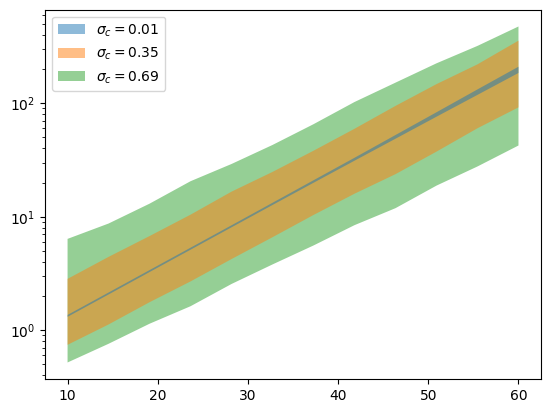

In [13]:
from itertools import islice
f, ax = plt.subplots()
zorder = 1 # just a hack to make to control the order of the layers in the plot
for sigma_c, idata in islice(idata_ensemble.items(), 0, None, 10):
    plot_timecourse_qs(
        ax,
        "pseudobatch_c",
        idata.posterior,
        samples['timestamp'],
        coords={"species": ["Biomass"]},
        alpha=0.5,
        label = f"$\sigma_c={sigma_c:.2f}$",
        zorder=zorder
    )
    zorder -=1
leg = ax.legend(loc="upper left")
sly = ax.semilogy()


It looks like that at larger $\sigma_c$ the posterior is moved towards horizontal.

In [14]:
# make a function which fits a log-linear model through pandas .apply
def fit_log_linear_model(df):
    x = df["time"].values
    y = df["pseudobatch_c"].values
    logy = np.log(y)
    slope, intercept = np.polyfit(x, logy, deg=1)
    return pd.Series([slope, intercept], index=['slope', 'intercept'])

fitted_growth_rates = pd.DataFrame()
for sigma_c, idata in islice(idata_ensemble.items(), 0, None, 10):
    # get the posterior of pseudo_batch_c
    posterior_df = (idata
        .posterior['pseudobatch_c'].sel(species="Biomass")
        .to_dataframe()
        .reset_index()
    )
    posterior_df['time'] = posterior_df['sample'].map(samples['timestamp'])

    fitted_growth_rates_tmp = (posterior_df
        .groupby(['chain', 'draw'])
        .apply(fit_log_linear_model) 
    )
    # add the sigma_c column
    fitted_growth_rates_tmp['sigma_c'] = sigma_c

    fitted_growth_rates = pd.concat([fitted_growth_rates, fitted_growth_rates_tmp])


0.025    0.071706
0.500    0.098683
0.975    0.108006
Name: slope, dtype: float64


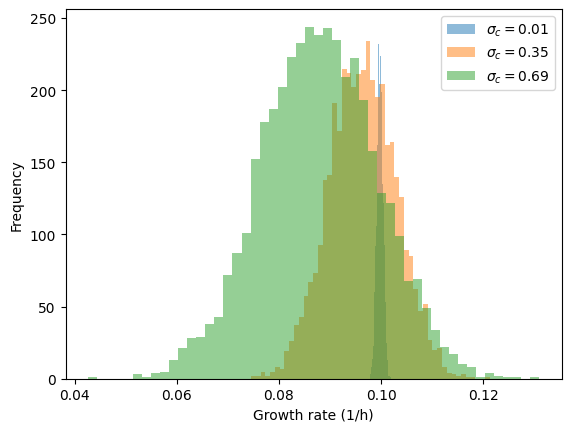

In [15]:
# plot a histogram of the fitted slopes (growth rates)

for sigma_c, group in fitted_growth_rates.groupby('sigma_c'):
    group.slope.plot.hist(bins=50, alpha=0.5, label=f"$\sigma_c={sigma_c:.2f}$")

plt.xlabel('Growth rate (1/h)')
plt.ylabel('Frequency')
plt.legend()

# the 0.025, 0.5 and 0.975 quantiles of the fitted slopes
print(fitted_growth_rates.slope.quantile([0.025, 0.5, 0.975]))

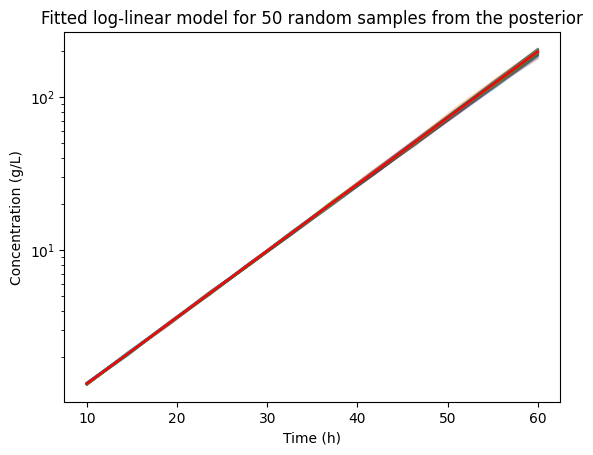

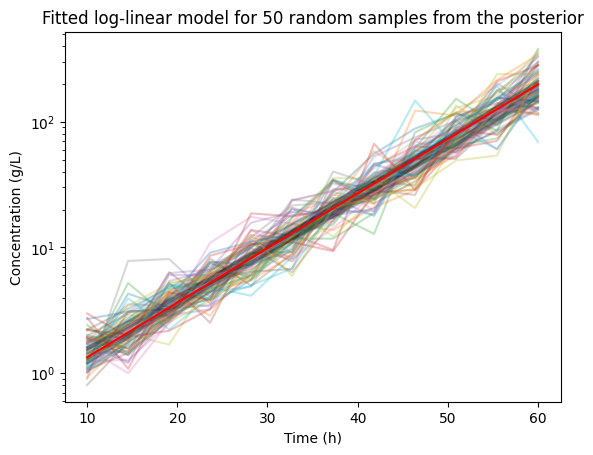

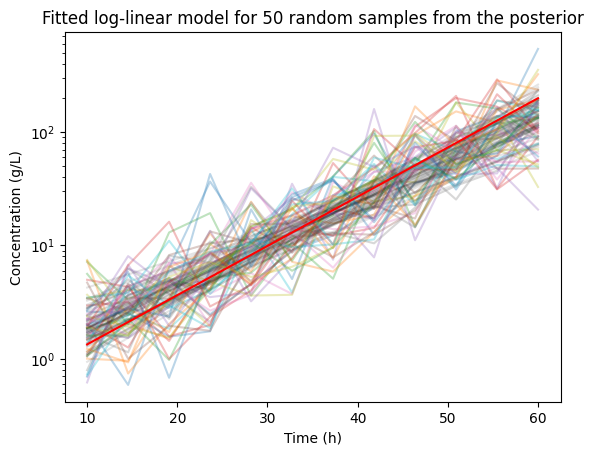

In [16]:
# select 50 random samples from the posterior and plot pseudo_batch_c
# and the fitted log-linear model
import matplotlib.colors as mcolors
norm = fitted_growth_rates.sigma_c.unique()
cmap = mcolors.ListedColormap(["C0", "C1", "C2"])
ax_num = 0
for sigma_c, group in fitted_growth_rates.groupby('sigma_c'):
    for (chain, draw), row in group.sample(50, random_state=42).iterrows():
        # plot the posterior samples of pseudo_batch_c
        posterior_x = samples['timestamp'].values
        posterior_y = idata_ensemble[sigma_c].posterior.sel(chain=chain, draw=draw, species="Biomass")['pseudobatch_c'].values
        plt.plot(posterior_x, posterior_y, '-', alpha=0.3)

        # plot the fitted log-linear model
        slope, intercept, _ = row
        x = np.linspace(posterior_x.min(), posterior_x.max(), 10)
        y = np.exp(intercept + slope * x)
        plt.plot(x, y, 'k', alpha=0.1)


    plt.plot(samples['timestamp'], samples['c_Biomass_pseudobatch'], color = 'red')
    plt.semilogy()
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/L)')
    plt.title('Fitted log-linear model for 50 random samples from the posterior')
    plt.show()


In [17]:
fitted_growth_rates.sigma_c.unique()

array([0.01      , 0.35137931, 0.69275862])

Thus, when the measurement error is ±10% the uncertainty of the pseudo batch concentration becomes ±11.59%. The error of the pseudo batch concentration also includes uncertainties in the volumes. This 

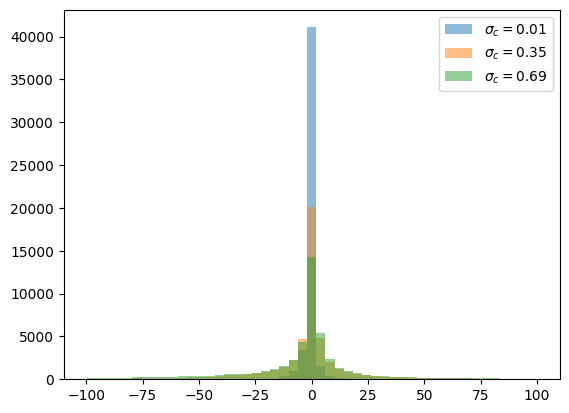

In [18]:

for sigma_c, idata in islice(idata_ensemble.items(), 0, None, 10):
    resid = (
        idata.posterior["pseudobatch_c"].sel(species="Biomass")
        - samples["c_Biomass_pseudobatch"].values
    ).to_dataframe().unstack("sample")["pseudobatch_c"]
 
    ax = plt.hist(resid.stack().values, bins=np.linspace(-100, 100), alpha=0.5, label=f"$\sigma_c={sigma_c:.2f}$")

plt.legend()

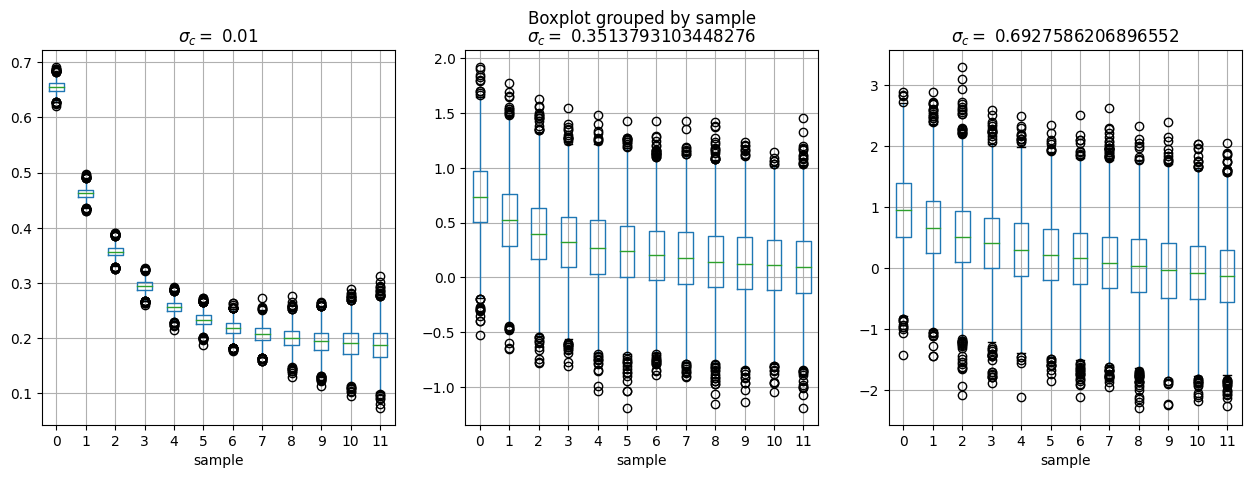

In [19]:
f, axes = plt.subplots(1, 3, figsize=[15, 5])
for ax, (sigma_c, idata) in zip(axes, islice(idata_ensemble.items(), 0, None, 10)):
    log_resid = (
        np.log(idata.posterior["pseudobatch_c"].sel(species="Biomass"))
        - np.log(samples["c_Product_pseudobatch"].values)
    ).to_dataframe().unstack("sample")["pseudobatch_c"]
    log_resid.stack().reset_index().rename(columns={0:"pseudobatch_c"}).boxplot("pseudobatch_c", by="sample", ax=ax)
    ax.set_title(f"$\sigma_c = $ {sigma_c}")

## A realistic examples of the error propagation

Now we wish to make an example of uncertainty of the pseudo batch concentrations with a realistic measurement error of the biomass concentration. We will assume that we are 95 % sure that the true biomass value lies within ±10% of the measured value. Therefore the standard deviation (of the log-normal distribution) of the measured concentration becomes $\frac{0.1}{1.96}$. We can draw 1000 samples with a hard-coded measurement standard deviation ($\sigma_c$). Then find width of the 95% credible interval, calculate the relative credible interval and finally divide this by 2 because the credible interval spans both sides of the expected value. 

In [20]:
def coefficient_of_variance(x: np.array)->float:
    """Calculate the coefficient of variance of a series"""
    return np.std(x) / np.mean(x)

In [21]:
expected_sigma_c = 0.05 # measurement CV, 95% centain that the value within ~±10% of the true value
known_quantities_realistic = KNOWN_QUANTITIES | {"sigma_c": [expected_sigma_c] * 3}
ep_args_realistic = ERROR_PROPAGATION_ARGS | {"known_quantities": known_quantities_realistic}

idata_realistic_example = run_error_propagation(**ep_args_realistic)

# low, high = idata_realistic_example.posterior["pseudo_batch_c"].quantile([0.025, 0.975], dim=["chain", "draw"])
end_point_samples = idata_realistic_example.posterior['pseudobatch_c'].sel(sample=11, species = 'Biomass').values
coefficient_of_variance_realistic_example = coefficient_of_variance(end_point_samples)
# width_realistic_example = (high - low).sel(sample=11, species = 'Biomass').values
# coefficient_of_variance_realistic_example = (width_realistic_example / 2) / samples["c_Biomass_pseudo"].iloc[11]
print(f"Coefficient of variance of the pseudo-batch value: {coefficient_of_variance_realistic_example:.2%}")
print(f"Relative error (95%) of the pseudo-batch value: {coefficient_of_variance_realistic_example*1.96:.2%}")

Coefficient of variance of the pseudo-batch value: 5.81%
Relative error (95%) of the pseudo-batch value: 11.38%


An increase of 5 % to 5.8% is actually quite large. Therefore, we investigate if the increase it due to uncertainty in the remaining parameters, volume, substrate in feed, pump bias etc. We will fit a new model with small uncertainty on these quantities.

In [22]:
KNOWN_QUANTITIES_LOW_UNCETRAINTY = {
    "sigma_v": 0.005,
    "sigma_c": [0.005] * 3,
    "sigma_f": 0.005,
    "sigma_s": 0.005,
    "sigma_cfeed": 0.005,
}

ep_args_low_uncertainty = ERROR_PROPAGATION_ARGS | {"known_quantities": KNOWN_QUANTITIES_LOW_UNCETRAINTY}
idata_low_uncertainty = run_error_propagation(**ep_args_low_uncertainty)

# low, high = idata_realistic_example.posterior["pseudo_batch_c"].quantile([0.025, 0.975], dim=["chain", "draw"])
end_point_samples_low_uncertainty = idata_low_uncertainty.posterior['pseudobatch_c'].sel(
    sample=11, species = 'Biomass'
).values
coefficient_of_variance_low_uncertainty = coefficient_of_variance(end_point_samples_low_uncertainty)
# width_realistic_example = (high - low).sel(sample=11, species = 'Biomass').values
# coefficient_of_variance_realistic_example = (width_realistic_example / 2) / samples["c_Biomass_pseudo"].iloc[11]
print(f"Coefficient of variance of the pseudo-batch value: {coefficient_of_variance_low_uncertainty:.2%}")
print(f"Relative error (95%) of the pseudo-batch value: {coefficient_of_variance_low_uncertainty*1.96:.2%}")

Coefficient of variance of the pseudo-batch value: 0.60%
Relative error (95%) of the pseudo-batch value: 1.17%
